In [1]:
path = "Outputs_electricity_test_inj/electricity/"
# path = "aaai_Outputs_electricity_e336_d168_testprune_2_rp/electricity/"
# path = "Outputs_electricity_e336_d168_original_huber/electricity/"
#path = "Outputs_synthetic/foodinflation/"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error
preds = np.load(path+'TRANS-MSE-AR_pred_mu.npy')
inputs = np.load(path+'inputs.npy')
trues = np.load(path+'targets.npy')
#preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
#trues = trues.reshape(-1, preds.shape[-2], preds.shape[-1])
# [samples, pred_len, dimensions]
print(preds.shape, trues.shape, inputs.shape)

print("mse : ",mean_squared_error(trues.squeeze(),preds.squeeze()),"mae: ",mean_absolute_error(trues.squeeze(),preds.squeeze()))

(54, 168, 1) (54, 168, 1) (54, 336)
mse :  6848.0386 mae:  59.226215


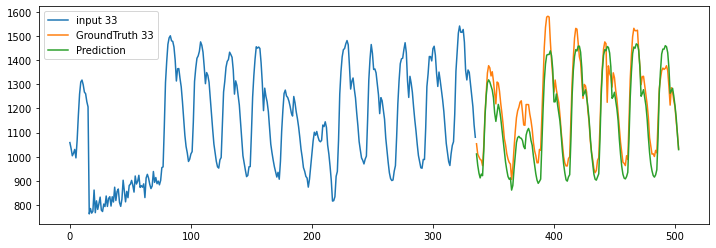

In [6]:
plt.rcParams['figure.figsize'] = (12,4)

plt.figure()
c =33
x = np.arange(504)
a = 336
plt.plot(x[:a],inputs[c],label='input '+str(c))

plt.plot(x[a:],trues[c,:,0], label='GroundTruth '+str(c))
#for i in range(1):
plt.plot(x[a:],preds[c,:,0], label='Prediction ')
plt.legend()
plt.show()